<h1>Predict2Tensor Development</h1>

In [3]:
from Bio import BiopythonWarning
import warnings
from Bio.PDB import *
from Bio.PDB.DSSP import DSSP

from operator import itemgetter
import csv
import itertools
import pickle
import tensorflow as tf
from keras.layers import RepeatVector, BatchNormalization, Input, add, concatenate, TimeDistributed, Bidirectional, LSTM, Dense, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout
from keras.models import Model, Sequential
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
import keras.backend as K
from sklearn.model_selection import train_test_split
import numpy as np
import pandas
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pydot
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from itertools import groupby
import random
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as ticker

In [ ]:
tf.keras.backend.clear_session()



resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://')
tf.config.experimental_connect_to_cluster(resolver)


tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.experimental.TPUStrategy(resolver)

This is used to connect to Google Cloud TPU instances.

In [25]:
AAcodes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '?']

SScodes = ['H', 'B', 'E', 'G', 'I', 'T', 'S', '-', '?']

def create_dict(codes):
    char_dict = {}
    for index, val in enumerate(codes):
        char_dict[val] = index

    return char_dict

aaDict = create_dict(AAcodes)
ssDict = create_dict(SScodes)
ssDictInverted = dict(map(reversed, ssDict.items()))
aaDictInverted = dict(map(reversed, aaDict.items()))


Adapted from the work of, this function is used to create enumeration dictionaries for which a protein can be 

<h2>Creating the Secondary Structure Database</h2>

In [4]:
p = PDBParser()
pdbl = PDBList() 
location = "/pdbfiles/unzipped/" #this is where your PDB backup is stored.
with open("fullList.csv", 'r') as file:
    reader = csv.reader(file)
    proteinList = list(reader)[0]
numProts = len(proteinList)


First, we configure the required objects for Biopython to parse and load in the list of proteins that have been preliminarily curated using the built in RCSB search tools.

In [ ]:
a = {}
b = {}
for i, prog in zip(proteinList, range(numProts)):
    try:
        data = p.get_structure(i,location+"pdb%s.ent" % i.lower()) #load in the file
    except:
        print("Could not read file!")
        continue
    protFrame = data[0] #grab the first frame
    print(str(prog/numProts* 100)+"%") #progress bar, yay!
    try:
        dssp = DSSP(protFrame, location+"pdb%s.ent" % i.lower()) #
    except:
        print("Could not read file!")
        continue
    keys = list(dssp.keys())
    chainDict = {}
    for j in keys:
        chain = j[0]
        residueChunk = dssp[j]
        if chain in chainDict:
            chainDict[chain].append(residueChunk)
        else:
            chainDict[chain] = [residueChunk]
    
    for key, value in chainDict.items():
        residue = list(map(itemgetter(1), value))
        structure = list(map(itemgetter(2), value))
        id =(i,key)
        print(id)
        a[id]=residue
        b[id] =structure

We go through the local copy of each file in the list, generate the secondary structure, extract the class information only, and store it in a dictionary with the PDB id and chain ID. 

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', BiopythonWarning)

    proteinFeatures = {}
    for i, prog in zip(proteinList, range(numProts)):
        try:
            data = p.get_structure(i,location+"pdb%s.ent" % i.lower()) #load in the file
        except:
            print("Could not read file!")
            continue
        keywords = data.header["keywords"]
        proteinFeatures[i] = keywords.split(',')
        percent = prog/numProts* 100
        if percent % 1 == 0:
            print(str(percent)+"%") #progress bar, yay!


For future work, we extract the keywords for each PDB file.

In [6]:
with open("keywords.pkl", 'wb') as f:
    pickle.dump(proteinFeatures, f)

In [4]:
with open('keywords.pkl', 'rb') as f:
    keywords = pickle.load(f)

In [ ]:
with open('a.pkl', 'wb') as f:
    pickle.dump(a, f)
with open('b.pkl', 'wb') as f:
    pickle.dump(b, f)

In [2]:
with open('a.pkl', 'rb') as f:
    a = pickle.load(f)
with open('b.pkl', 'rb') as f:
    b = pickle.load(f)    

The unrefined datasets of sequences and keywords are saved in the python pickle format for being recalled at a later time. 

In [5]:
wordBook = {}
keywordsNew = {}
refinedKeywords = []
for i,j in keywords.items():
    newList = []
    for k in j:
        cleaned = k.strip().lower()
        newList.append(cleaned)
        wordBook[cleaned] = wordBook.get(cleaned, 0)+1 or 1
        
    keywordsNew[i] = newList
print(len(keywordsNew))
print(len(wordBook))
limiter = 0
for i,j in wordBook.items():
    if j >= 400:
        refinedKeywords.append(i)
    
keywordCodes = create_dict(wordBook.keys())
len(keywordCodes)
badWords = ['sgc', 'structural genomics consortium', 'structural genomics', 'national institute of allergy and infectious diseases', 'nysgrc', 'joint center for structural genomics', 'jcsg', 'protein structure initiative', 'psi-2','new york sgx research center for structural genomics', 'nysgxrc', 'midwest center for structural genomics', 'mcsg', 'nppsfa', 'national project on protein structural and functional analyses', 'riken structural genomics/proteomics initiative', 'rsgi', 'nesg', 'northeast structural genomics consortium', 'center for structural genomics of infectious diseases', 'csgid', 'psi-biology', 'seattle structural genomics center for infectious disease', 'ssgcid', 'niaid', 'fragment screening', 'nmr', 'pandda', 'sgc - diamond i04-1 fragment screening', 'xchemexplorer']
for i in badWords:
    refinedKeywords.remove(i)
print(refinedKeywords)
keywordDict = create_dict(refinedKeywords)
len(refinedKeywords)

150834
89489
['alternative splicing', 'endoplasmic reticulum', 'glycoprotein', 'ion transport', 'lipoprotein', 'membrane', 'phosphoprotein', 'transmembrane', 'transport', 'transport protein', 'fab', 'immune system', 'atp-binding', 'kinase', 'nucleotide-binding', 'transferase', 'hydrolase', 'secreted', 'antibiotic resistance', 'allostery', 'dehydrogenase', 'magnesium', 'metal-binding', 'nad', 'oxidoreductase', 'chaperone', 'cytoplasm', 'rossmann fold', 'unknown function', 'glycosyltransferase', 'nucleus', 'polymorphism', 'serine/threonine-protein kinase', 'transcription regulation', 'acetylation', 'cell cycle', 'cell division', 'coiled coil', 'transcription', 'lyase', 'tim barrel', 'glycosidase', 'protein transport', 'disease mutation', 'serine protease', 'biosynthetic protein', 'inhibitor', 'cytokine', 'structural protein', 'apoptosis', 'cell adhesion', 'ligase', 'rna binding protein', 'antibody', 'methyltransferase', 'membrane protein', 'enzyme', 'mutant', 'isomerase', 'dna repair', '

146

Investigating the keywords that are highly common. Additionally, we remove keywords that are related to data collection like the laboratory or method.

<h2>Refine The Dataset</h2>

In [67]:
with open("/home/theo/jigglingneurons/tmp/singleChains.csv", 'r') as file:
    reader = csv.reader(file)
    monoProteinList = list(reader)[0]
tempA = {}
tempB = {}
for i in monoProteinList:
    try:
        tempA[(i, 'A')] = a.pop((i, 'A'))
        tempB[(i, 'A')] = b.pop((i, 'A'))
    except:
        print("Could not find protein!")
complexProteins = set(proteinList) - set(monoProteinList)
for i in complexProteins:
    entrySeq = {key:value for key, value in a.items() if i == key[0]}
    entryStruc = {key:value for key, value in b.items() if i == key[0]}
    hits = []
    dupes = []
    for i,j in entrySeq.items():
        if j in hits:
            dupes.append(i)
        else:
            hits.append(j)
    for i in dupes:
        entrySeq.pop(i)
        entryStruc.pop(i)
    tempA.update(entrySeq)
    tempB.update(entryStruc)

Now, for the training data, we remove any redundant chains. We go through and do this automatically for proteins we determined only have one chain through RCSB search to save time, and then do it programmatically for the rest.

In [70]:
with open('a_singleton.pkl', 'wb') as f:
    pickle.dump(tempA, f)
with open('b_singleton.pkl', 'wb') as f:
    pickle.dump(tempB, f)

In [63]:
with open('a_singleton.pkl', 'rb') as f:
    a = pickle.load(f)
with open('b_singleton.pkl', 'rb') as f:
    b = pickle.load(f)    

And save the data for later use.

In [4]:
def listStats(listTo):
    q = 0
    modeList = []
    for i in listTo:
        modeList.append(len(i))
        q += len(i)


    q= q/len(listTo)
    print(q)
    z = 0 
    for i in listTo:
        if len(i) < q:
            z += 1
    print(print("Which includes " +str(z) + " seqeuences"))
    print("Mode: " + str(max(set(modeList), key=modeList.count)))
    print("Min: " + str(min(modeList)))
    print("Max: " + str(max(modeList)))
listStats(list(a.values()))
print(len(a))

242.08403821668625
Which includes 118892 seqeuences
None
Mode: 99
Min: 1
Max: 3930
202634


We define and use a function listStats. This gives us the average length of a sequence, the mode, the minimum, and the maximum, as well as how many sequences are included if the mean is used as a cutoff. 

<h2>Prepare The Dataset for the Network</h2>

In [11]:
def dataPrepare(parsingList, someDict, cap):
    for i in parsingList:
        for j in range(len(i)): #encoding the characters as numbers.
            if i[j] not in someDict:
                i[j] = someDict['?']
            else:
                i[j] = someDict[i[j]]
    
    padded_parsingList = tf.keras.preprocessing.sequence.pad_sequences(
        parsingList, padding="post", value = someDict['?'], maxlen= 250
    ) #to auto pad or truncate off the saequence
    padded_parsingList = padded_parsingList.reshape((padded_parsingList.shape[0], padded_parsingList.shape[1], 1)) #making each amino acid a 1-long list 
    padded_parsingList = np_utils.to_categorical(padded_parsingList) #and then expand it to a 20-long list
    return padded_parsingList[:,:, :cap]

This function then converts the now pruned dataset into a format acceptable for the neural network. It translates each sequence into a data structure of the shape [250, 20] where 250 is the sequence size and 20 is a one hot encoded amino acid.

In [9]:
padded_a = dataPrepareB(list(a.values()), aaDict. 20)
padded_b = dataPrepareB(list(b.values()), ssDict, 8)


(202634, 250, 21)


In [114]:
print(padded_a.shape, keywords_a.shape)

(202634, 250, 20) (202634, 146)


In [95]:
with open('a_padded_keywords.pkl', 'wb') as f:
    pickle.dump(padded_a, f)
with open('b_padded_keywords.pkl', 'wb') as f:
    pickle.dump(padded_b, f)

In [61]:
with open('a_padded.pkl', 'rb') as f:
    padded_a = pickle.load(f)
with open('b_padded.pkl', 'rb') as f:
    padded_b = pickle.load(f)

For saving and loading the properly shaped data.

In [65]:
a_train, a_test, b_train, b_test = train_test_split(padded_a.astype(np.uint8), padded_b.astype(np.uint8), test_size=0.10, random_state=2) #split into training and testing sets



In [20]:
print(a_train.shape, a_test.shape)
print(b_train.shape, b_test.shape)

(182370, 250, 20) (20264, 250, 20)
(182370, 250, 8) (20264, 250, 8)


In [6]:
def subsetDemographics(array_a, array_b):
    newArray_a = []
    newArray_b = []
    underrepresented = [1, 3, 4, 6]
    reformat = np.argmax(array_b, axis =-1)
    for i,k,l in zip(reformat, array_a, array_b):
        
        for j in underrepresented:
            if j in i:
                newArray_a.append(k)
                newArray_b.append(l)
                break
                
    return np.array(newArray_a), np.array(newArray_b)
newA, newB = subsetDemographics(a_train, b_train)
len(newA)

<h2>Model Configuration And Training</h2>

In [ ]:
class AccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self, a_test, b_test):
        self.a_test = a_test
        self.b_test = b_test
    def on_epoch_end(self, epoch, logs=None):
        pred = np.argmax(model.predict(a_test), axis=-1)
        prey = np.argmax(b_test, axis =-1)
        prey = list(itertools.chain.from_iterable(prey))
        pred = list(itertools.chain.from_iterable(pred))
        print(classification_report(prey, pred, target_names=SScodes[:-1]))
        
        
accuracy_callback = AccuracyCallback(a_test, b_test)

The above function accepts a callback object from tensorflow, and thus can be executed at different points in the training. In the case of this model, this callback function runs at the end of each epoch, and returns the individual classification accuracies.

In [2]:
with strategy.scope(): 
    model = Sequential() 
    #model.add(tf.keras.layers.Masking(mask_value=0., input_shape=(250, 20))) #ignore any value of -1
    #model.add(Conv1D(filters=250, kernel_size=8, activation='sigmoid', padding="same", input_shape=(250,20)))

    model.add(Bidirectional(LSTM(units=500, recurrent_dropout=0.3, return_sequences=True))) #remembers last input
    model.add(Bidirectional(LSTM(units=250, input_dim=20,recurrent_dropout=0.2, return_sequences = True))) #remembers last input
    model.add(Bidirectional(LSTM(units=100, input_dim=20,recurrent_dropout=0.2, return_sequences = True))) #remembers last input
    model.add(Bidirectional(LSTM(units=50, input_dim=20,recurrent_dropout=0.2, return_sequences = True))) #remembers last input
    model.add(Dense(8, activation='softmax'))

    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    model.build(input_shape = (None,250, 20))
    plot_model(model, "keyword_model.png", show_shapes=True)

    print(model.summary())    
     

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 250, 1000)         2084000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 250, 500)          2502000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 250, 200)          480800    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 250, 100)          100400    
_________________________________________________________________
dense (Dense)                (None, 250, 8)            808       
Total params: 5,168,008
Trainable params: 5,168,008
Non-trainable params: 0
_________________________________________________________________
None


The above function generates the model.

In [58]:
history = model.fit(a_train.astype(np.int8),
                    b_train.astype(np.int8),
                    batch_size=128,
                    validation_split=0.33,
                    callbacks=[accuracy_callback],
                    epochs=5
                    )

The output of the above code block has been stored elsewhere. See appendix.

In [13]:
model.save('gs://theo_tpustorage/goodssmodel3')

<h2>Model Analysis</h2>

In [4]:
model = tf.keras.models.load_model('/home/theo/predict2tensor/ssmodel/1')

In [10]:
def howClose(y_true, y_pred):
    overallA = 0
    overallB = 0
    for i, j in zip(y_true, y_pred):
        totalSites = 0
        hitSites = 0
        trueGroups = [(key, len(list(val))) for key, val in groupby(i)]
        truePreds = [(key, len(list(val))) for key, val in groupby(j)]
        for i in trueGroups:
            if i in truePreds:
                hitSites += 1
            totalSites += 1
        overallA += hitSites/totalSites
        totalSites = 0
        hitSites = 0
        for i in truePreds:
            if i in trueGroups:
                hitSites += 1
            totalSites += 1
        overallB += hitSites/totalSites
    return (overallA/len(y_true),overallB/len(y_true) )

This function defines the "Definition" metric, which represents the percentage of start and end sites in sequence a that appear in sequence b, and vice versa. It is used to compare the actual and predicted secondary structure.

In [8]:
a_fractions = [[],[],[],[],[], []]
b_fractions = [[],[],[],[],[], []]
print(a_test.shape)
blank = [0 for x in range(0,20)]
for i, j in zip(a_test, b_test):
    count = 0
    for k in i:
        if (k == blank).all():
            break
        else:
            count += 1
    placement = int((count - (count % 50))/ 50)
    print((count, placement))
    a_fractions[placement].append(i)
    b_fractions[placement].append(j)

(20264, 250, 20)
(77, 1)
(6, 0)
(154, 3)
(243, 4)
(28, 0)
(250, 5)
(47, 0)
(250, 5)
(141, 2)
(5, 0)
(250, 5)
(250, 5)
(237, 4)
(70, 1)
(250, 5)
(130, 2)
(250, 5)
(250, 5)
(61, 1)
(250, 5)
(250, 5)
(82, 1)
(10, 0)
(192, 3)
(250, 5)
(96, 1)
(59, 1)
(174, 3)
(11, 0)
(34, 0)
(147, 2)
(209, 4)
(124, 2)
(250, 5)
(21, 0)
(145, 2)
(250, 5)
(250, 5)
(250, 5)
(219, 4)
(218, 4)
(74, 1)
(250, 5)
(217, 4)
(250, 5)
(250, 5)
(76, 1)
(250, 5)
(250, 5)
(250, 5)
(139, 2)
(227, 4)
(229, 4)
(134, 2)
(167, 3)
(250, 5)
(3, 0)
(22, 0)
(3, 0)
(32, 0)
(135, 2)
(250, 5)
(118, 2)
(118, 2)
(248, 4)
(148, 2)
(115, 2)
(20, 0)
(250, 5)
(250, 5)
(230, 4)
(233, 4)
(24, 0)
(10, 0)
(250, 5)
(238, 4)
(250, 5)
(249, 4)
(250, 5)
(56, 1)
(13, 0)
(250, 5)
(149, 2)
(250, 5)
(198, 3)
(250, 5)
(57, 1)
(250, 5)
(196, 3)
(0, 0)
(204, 4)
(61, 1)
(100, 2)
(218, 4)
(97, 1)
(250, 5)
(97, 1)
(250, 5)
(138, 2)
(89, 1)
(250, 5)
(100, 2)
(250, 5)
(52, 1)
(98, 1)
(250, 5)
(238, 4)
(241, 4)
(9, 0)
(250, 5)
(107, 2)
(218, 4)
(250, 5)
(0, 0)

(249, 4)
(250, 5)
(75, 1)
(34, 0)
(115, 2)
(131, 2)
(116, 2)
(245, 4)
(32, 0)
(73, 1)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(219, 4)
(250, 5)
(182, 3)
(161, 3)
(250, 5)
(250, 5)
(250, 5)
(23, 0)
(138, 2)
(250, 5)
(0, 0)
(231, 4)
(250, 5)
(250, 5)
(187, 3)
(239, 4)
(123, 2)
(250, 5)
(7, 0)
(235, 4)
(250, 5)
(206, 4)
(250, 5)
(91, 1)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(169, 3)
(204, 4)
(113, 2)
(250, 5)
(7, 0)
(250, 5)
(250, 5)
(84, 1)
(250, 5)
(154, 3)
(250, 5)
(216, 4)
(126, 2)
(247, 4)
(53, 1)
(157, 3)
(216, 4)
(82, 1)
(88, 1)
(132, 2)
(214, 4)
(35, 0)
(14, 0)
(250, 5)
(250, 5)
(250, 5)
(37, 0)
(250, 5)
(250, 5)
(87, 1)
(132, 2)
(138, 2)
(130, 2)
(97, 1)
(250, 5)
(10, 0)
(243, 4)
(150, 3)
(152, 3)
(250, 5)
(28, 0)
(0, 0)
(76, 1)
(250, 5)
(99, 1)
(14, 0)
(46, 0)
(250, 5)
(1, 0)
(250, 5)
(249, 4)
(55, 1)
(212, 4)
(159, 3)
(42, 0)
(182, 3)
(250, 5)
(221, 4)
(206, 4)
(250, 5)
(78, 1)
(241, 4)
(23, 0)
(250, 5)
(250, 5)
(124, 2)
(250, 5)
(250, 5)
(164, 3)
(250, 5)
(92, 1)
(250, 5)
(

(211, 4)
(250, 5)
(177, 3)
(143, 2)
(167, 3)
(72, 1)
(250, 5)
(141, 2)
(250, 5)
(250, 5)
(224, 4)
(241, 4)
(104, 2)
(211, 4)
(158, 3)
(207, 4)
(99, 1)
(250, 5)
(117, 2)
(250, 5)
(250, 5)
(6, 0)
(249, 4)
(72, 1)
(250, 5)
(71, 1)
(142, 2)
(170, 3)
(250, 5)
(226, 4)
(250, 5)
(172, 3)
(173, 3)
(145, 2)
(236, 4)
(155, 3)
(250, 5)
(119, 2)
(250, 5)
(244, 4)
(182, 3)
(250, 5)
(166, 3)
(180, 3)
(250, 5)
(250, 5)
(2, 0)
(66, 1)
(190, 3)
(193, 3)
(137, 2)
(177, 3)
(250, 5)
(250, 5)
(79, 1)
(250, 5)
(214, 4)
(250, 5)
(177, 3)
(98, 1)
(105, 2)
(5, 0)
(250, 5)
(250, 5)
(103, 2)
(39, 0)
(250, 5)
(250, 5)
(238, 4)
(218, 4)
(250, 5)
(250, 5)
(215, 4)
(250, 5)
(23, 0)
(246, 4)
(163, 3)
(241, 4)
(78, 1)
(250, 5)
(130, 2)
(250, 5)
(114, 2)
(212, 4)
(87, 1)
(155, 3)
(105, 2)
(89, 1)
(250, 5)
(104, 2)
(119, 2)
(191, 3)
(250, 5)
(250, 5)
(250, 5)
(242, 4)
(99, 1)
(61, 1)
(8, 0)
(170, 3)
(250, 5)
(5, 0)
(11, 0)
(96, 1)
(242, 4)
(227, 4)
(250, 5)
(92, 1)
(20, 0)
(92, 1)
(0, 0)
(233, 4)
(190, 3)
(250, 5)
(238,

(31, 0)
(231, 4)
(152, 3)
(250, 5)
(229, 4)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(121, 2)
(250, 5)
(125, 2)
(230, 4)
(250, 5)
(110, 2)
(163, 3)
(250, 5)
(40, 0)
(225, 4)
(20, 0)
(138, 2)
(137, 2)
(11, 0)
(250, 5)
(250, 5)
(185, 3)
(250, 5)
(47, 0)
(147, 2)
(124, 2)
(147, 2)
(215, 4)
(198, 3)
(250, 5)
(148, 2)
(190, 3)
(117, 2)
(56, 1)
(250, 5)
(250, 5)
(213, 4)
(11, 0)
(64, 1)
(250, 5)
(246, 4)
(80, 1)
(217, 4)
(123, 2)
(212, 4)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(74, 1)
(250, 5)
(212, 4)
(76, 1)
(99, 1)
(250, 5)
(250, 5)
(250, 5)
(204, 4)
(250, 5)
(250, 5)
(250, 5)
(44, 0)
(250, 5)
(250, 5)
(250, 5)
(87, 1)
(250, 5)
(150, 3)
(250, 5)
(250, 5)
(162, 3)
(246, 4)
(250, 5)
(250, 5)
(250, 5)
(196, 3)
(250, 5)
(250, 5)
(215, 4)
(33, 0)
(9, 0)
(110, 2)
(250, 5)
(183, 3)
(105, 2)
(250, 5)
(107, 2)
(18, 0)
(14, 0)
(250, 5)
(250, 5)
(250, 5)
(182, 3)
(106, 2)
(99, 1)
(234, 4)
(8, 0)
(250, 5)
(118, 2)
(238, 4)
(62, 1)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(61, 1)
(250, 5)
(250, 5)
(135, 2

(158, 3)
(213, 4)
(250, 5)
(41, 0)
(154, 3)
(51, 1)
(250, 5)
(136, 2)
(100, 2)
(77, 1)
(71, 1)
(219, 4)
(103, 2)
(49, 0)
(250, 5)
(250, 5)
(65, 1)
(250, 5)
(3, 0)
(250, 5)
(250, 5)
(250, 5)
(225, 4)
(212, 4)
(3, 0)
(141, 2)
(70, 1)
(190, 3)
(250, 5)
(193, 3)
(100, 2)
(64, 1)
(19, 0)
(250, 5)
(250, 5)
(121, 2)
(250, 5)
(211, 4)
(28, 0)
(50, 1)
(41, 0)
(250, 5)
(93, 1)
(250, 5)
(58, 1)
(189, 3)
(250, 5)
(250, 5)
(130, 2)
(6, 0)
(152, 3)
(234, 4)
(250, 5)
(250, 5)
(250, 5)
(170, 3)
(185, 3)
(74, 1)
(175, 3)
(214, 4)
(250, 5)
(250, 5)
(15, 0)
(250, 5)
(196, 3)
(218, 4)
(250, 5)
(24, 0)
(250, 5)
(213, 4)
(112, 2)
(250, 5)
(218, 4)
(250, 5)
(240, 4)
(250, 5)
(250, 5)
(185, 3)
(81, 1)
(0, 0)
(218, 4)
(4, 0)
(250, 5)
(149, 2)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(87, 1)
(250, 5)
(250, 5)
(66, 1)
(234, 4)
(47, 0)
(250, 5)
(135, 2)
(250, 5)
(107, 2)
(250, 5)
(250, 5)
(171, 3)
(250, 5)
(212, 4)
(60, 1)
(222, 4)
(213, 4)
(247, 4)
(208, 4)
(218, 4)
(49, 0

(116, 2)
(250, 5)
(64, 1)
(250, 5)
(138, 2)
(184, 3)
(250, 5)
(250, 5)
(238, 4)
(219, 4)
(250, 5)
(200, 4)
(250, 5)
(70, 1)
(9, 0)
(250, 5)
(250, 5)
(250, 5)
(64, 1)
(108, 2)
(2, 0)
(185, 3)
(250, 5)
(197, 3)
(87, 1)
(234, 4)
(113, 2)
(4, 0)
(222, 4)
(250, 5)
(59, 1)
(250, 5)
(106, 2)
(142, 2)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(247, 4)
(217, 4)
(250, 5)
(15, 0)
(99, 1)
(250, 5)
(162, 3)
(104, 2)
(250, 5)
(49, 0)
(108, 2)
(85, 1)
(209, 4)
(38, 0)
(40, 0)
(230, 4)
(229, 4)
(250, 5)
(192, 3)
(9, 0)
(10, 0)
(148, 2)
(179, 3)
(88, 1)
(250, 5)
(181, 3)
(9, 0)
(250, 5)
(121, 2)
(250, 5)
(198, 3)
(173, 3)
(123, 2)
(250, 5)
(98, 1)
(250, 5)
(127, 2)
(33, 0)
(70, 1)
(81, 1)
(250, 5)
(250, 5)
(92, 1)
(144, 2)
(250, 5)
(94, 1)
(175, 3)
(121, 2)
(30, 0)
(32, 0)
(129, 2)
(250, 5)
(250, 5)
(16, 0)
(250, 5)
(242, 4)
(154, 3)
(250, 5)
(250, 5)
(8, 0)
(77, 1)
(104, 2)
(250, 5)
(246, 4)
(250, 5)
(250, 5)
(129, 2)
(36, 0)
(250, 5)
(77, 1)
(177, 3)
(79, 1)
(149, 2)
(250, 5)
(250, 5)
(230, 4)
(14

(250, 5)
(246, 4)
(250, 5)
(45, 0)
(212, 4)
(31, 0)
(224, 4)
(250, 5)
(89, 1)
(250, 5)
(250, 5)
(0, 0)
(98, 1)
(74, 1)
(177, 3)
(225, 4)
(250, 5)
(250, 5)
(20, 0)
(250, 5)
(89, 1)
(67, 1)
(127, 2)
(250, 5)
(216, 4)
(250, 5)
(250, 5)
(38, 0)
(42, 0)
(94, 1)
(250, 5)
(250, 5)
(152, 3)
(146, 2)
(17, 0)
(233, 4)
(244, 4)
(250, 5)
(250, 5)
(250, 5)
(3, 0)
(35, 0)
(250, 5)
(52, 1)
(250, 5)
(250, 5)
(98, 1)
(170, 3)
(4, 0)
(129, 2)
(250, 5)
(3, 0)
(15, 0)
(3, 0)
(250, 5)
(164, 3)
(150, 3)
(250, 5)
(67, 1)
(3, 0)
(250, 5)
(205, 4)
(250, 5)
(245, 4)
(250, 5)
(132, 2)
(141, 2)
(250, 5)
(144, 2)
(128, 2)
(82, 1)
(214, 4)
(250, 5)
(250, 5)
(137, 2)
(250, 5)
(250, 5)
(110, 2)
(143, 2)
(250, 5)
(241, 4)
(250, 5)
(92, 1)
(250, 5)
(136, 2)
(143, 2)
(49, 0)
(121, 2)
(2, 0)
(103, 2)
(250, 5)
(78, 1)
(250, 5)
(231, 4)
(214, 4)
(10, 0)
(250, 5)
(129, 2)
(217, 4)
(79, 1)
(181, 3)
(84, 1)
(250, 5)
(22, 0)
(250, 5)
(46, 0)
(148, 2)
(250, 5)
(207, 4)
(164, 3)
(26, 0)
(80, 1)
(93, 1)
(41, 0)
(30, 0)
(250, 5)
(

(240, 4)
(250, 5)
(250, 5)
(246, 4)
(250, 5)
(113, 2)
(250, 5)
(29, 0)
(115, 2)
(245, 4)
(100, 2)
(250, 5)
(218, 4)
(250, 5)
(228, 4)
(150, 3)
(139, 2)
(237, 4)
(153, 3)
(3, 0)
(115, 2)
(250, 5)
(213, 4)
(178, 3)
(45, 0)
(250, 5)
(29, 0)
(250, 5)
(250, 5)
(226, 4)
(183, 3)
(58, 1)
(11, 0)
(45, 0)
(74, 1)
(217, 4)
(20, 0)
(250, 5)
(172, 3)
(146, 2)
(170, 3)
(250, 5)
(250, 5)
(250, 5)
(197, 3)
(237, 4)
(54, 1)
(109, 2)
(156, 3)
(217, 4)
(37, 0)
(6, 0)
(3, 0)
(250, 5)
(250, 5)
(110, 2)
(250, 5)
(226, 4)
(8, 0)
(227, 4)
(250, 5)
(61, 1)
(104, 2)
(62, 1)
(99, 1)
(250, 5)
(6, 0)
(44, 0)
(6, 0)
(250, 5)
(90, 1)
(250, 5)
(0, 0)
(9, 0)
(250, 5)
(85, 1)
(123, 2)
(250, 5)
(202, 4)
(219, 4)
(14, 0)
(25, 0)
(250, 5)
(42, 0)
(3, 0)
(173, 3)
(38, 0)
(105, 2)
(3, 0)
(250, 5)
(12, 0)
(250, 5)
(119, 2)
(250, 5)
(41, 0)
(250, 5)
(213, 4)
(162, 3)
(229, 4)
(234, 4)
(250, 5)
(16, 0)
(250, 5)
(109, 2)
(121, 2)
(250, 5)
(250, 5)
(119, 2)
(250, 5)
(170, 3)
(216, 4)
(250, 5)
(92, 1)
(160, 3)
(235, 4)
(250, 5)


(250, 5)
(99, 1)
(250, 5)
(250, 5)
(15, 0)
(45, 0)
(179, 3)
(124, 2)
(173, 3)
(213, 4)
(250, 5)
(0, 0)
(189, 3)
(222, 4)
(250, 5)
(212, 4)
(250, 5)
(250, 5)
(137, 2)
(142, 2)
(223, 4)
(153, 3)
(124, 2)
(250, 5)
(250, 5)
(157, 3)
(212, 4)
(210, 4)
(114, 2)
(237, 4)
(250, 5)
(14, 0)
(223, 4)
(250, 5)
(21, 0)
(53, 1)
(5, 0)
(250, 5)
(168, 3)
(153, 3)
(75, 1)
(122, 2)
(250, 5)
(250, 5)
(96, 1)
(250, 5)
(250, 5)
(1, 0)
(82, 1)
(250, 5)
(116, 2)
(2, 0)
(223, 4)
(172, 3)
(144, 2)
(250, 5)
(214, 4)
(250, 5)
(159, 3)
(59, 1)
(118, 2)
(1, 0)
(3, 0)
(172, 3)
(56, 1)
(29, 0)
(250, 5)
(86, 1)
(218, 4)
(178, 3)
(165, 3)
(250, 5)
(75, 1)
(63, 1)
(98, 1)
(10, 0)
(250, 5)
(178, 3)
(99, 1)
(8, 0)
(220, 4)
(43, 0)
(250, 5)
(79, 1)
(25, 0)
(112, 2)
(84, 1)
(13, 0)
(250, 5)
(250, 5)
(70, 1)
(250, 5)
(226, 4)
(74, 1)
(163, 3)
(105, 2)
(164, 3)
(229, 4)
(242, 4)
(6, 0)
(148, 2)
(184, 3)
(250, 5)
(134, 2)
(115, 2)
(250, 5)
(21, 0)
(250, 5)
(82, 1)
(250, 5)
(3, 0)
(99, 1)
(250, 5)
(92, 1)
(213, 4)
(250, 5)
(32

(250, 5)
(106, 2)
(250, 5)
(234, 4)
(250, 5)
(250, 5)
(94, 1)
(242, 4)
(72, 1)
(250, 5)
(250, 5)
(215, 4)
(11, 0)
(3, 0)
(250, 5)
(115, 2)
(235, 4)
(181, 3)
(152, 3)
(212, 4)
(113, 2)
(26, 0)
(250, 5)
(250, 5)
(250, 5)
(163, 3)
(45, 0)
(250, 5)
(13, 0)
(124, 2)
(250, 5)
(130, 2)
(206, 4)
(250, 5)
(250, 5)
(60, 1)
(249, 4)
(238, 4)
(80, 1)
(8, 0)
(204, 4)
(6, 0)
(185, 3)
(236, 4)
(153, 3)
(158, 3)
(119, 2)
(250, 5)
(3, 0)
(244, 4)
(250, 5)
(250, 5)
(199, 3)
(250, 5)
(250, 5)
(103, 2)
(250, 5)
(225, 4)
(211, 4)
(250, 5)
(250, 5)
(243, 4)
(250, 5)
(227, 4)
(23, 0)
(250, 5)
(250, 5)
(250, 5)
(64, 1)
(125, 2)
(72, 1)
(0, 0)
(224, 4)
(250, 5)
(174, 3)
(250, 5)
(243, 4)
(168, 3)
(100, 2)
(75, 1)
(250, 5)
(179, 3)
(250, 5)
(121, 2)
(228, 4)
(77, 1)
(202, 4)
(214, 4)
(68, 1)
(204, 4)
(250, 5)
(203, 4)
(162, 3)
(250, 5)
(70, 1)
(99, 1)
(171, 3)
(175, 3)
(10, 0)
(250, 5)
(250, 5)
(231, 4)
(167, 3)
(128, 2)
(121, 2)
(80, 1)
(0, 0)
(250, 5)
(174, 3)
(250, 5)
(166, 3)
(103, 2)
(81, 1)
(250, 5)
(113,

(185, 3)
(164, 3)
(7, 0)
(115, 2)
(250, 5)
(52, 1)
(170, 3)
(33, 0)
(103, 2)
(250, 5)
(250, 5)
(51, 1)
(250, 5)
(226, 4)
(161, 3)
(241, 4)
(33, 0)
(3, 0)
(250, 5)
(140, 2)
(250, 5)
(30, 0)
(39, 0)
(250, 5)
(73, 1)
(154, 3)
(118, 2)
(93, 1)
(250, 5)
(250, 5)
(250, 5)
(9, 0)
(250, 5)
(235, 4)
(250, 5)
(176, 3)
(250, 5)
(118, 2)
(44, 0)
(183, 3)
(62, 1)
(145, 2)
(0, 0)
(102, 2)
(114, 2)
(151, 3)
(250, 5)
(250, 5)
(24, 0)
(105, 2)
(33, 0)
(157, 3)
(250, 5)
(140, 2)
(179, 3)
(247, 4)
(250, 5)
(250, 5)
(243, 4)
(56, 1)
(25, 0)
(250, 5)
(65, 1)
(75, 1)
(250, 5)
(0, 0)
(145, 2)
(17, 0)
(116, 2)
(215, 4)
(34, 0)
(69, 1)
(250, 5)
(250, 5)
(250, 5)
(111, 2)
(209, 4)
(79, 1)
(115, 2)
(127, 2)
(142, 2)
(41, 0)
(250, 5)
(172, 3)
(149, 2)
(111, 2)
(227, 4)
(250, 5)
(115, 2)
(233, 4)
(250, 5)
(250, 5)
(103, 2)
(250, 5)
(52, 1)
(1, 0)
(250, 5)
(250, 5)
(177, 3)
(212, 4)
(50, 1)
(100, 2)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(114, 2)
(197, 3)
(72, 1)
(123, 2)
(44, 0)
(9, 0)
(98, 1)
(241,

(204, 4)
(135, 2)
(207, 4)
(243, 4)
(189, 3)
(78, 1)
(250, 5)
(30, 0)
(75, 1)
(250, 5)
(250, 5)
(217, 4)
(20, 0)
(202, 4)
(250, 5)
(111, 2)
(250, 5)
(116, 2)
(130, 2)
(250, 5)
(250, 5)
(250, 5)
(8, 0)
(250, 5)
(250, 5)
(70, 1)
(250, 5)
(23, 0)
(208, 4)
(58, 1)
(33, 0)
(9, 0)
(206, 4)
(1, 0)
(181, 3)
(9, 0)
(250, 5)
(250, 5)
(0, 0)
(250, 5)
(149, 2)
(250, 5)
(106, 2)
(192, 3)
(4, 0)
(71, 1)
(145, 2)
(250, 5)
(250, 5)
(81, 1)
(59, 1)
(245, 4)
(250, 5)
(26, 0)
(250, 5)
(250, 5)
(250, 5)
(171, 3)
(16, 0)
(125, 2)
(250, 5)
(250, 5)
(1, 0)
(250, 5)
(250, 5)
(250, 5)
(165, 3)
(58, 1)
(168, 3)
(207, 4)
(153, 3)
(250, 5)
(46, 0)
(219, 4)
(65, 1)
(250, 5)
(209, 4)
(250, 5)
(100, 2)
(173, 3)
(125, 2)
(250, 5)
(224, 4)
(250, 5)
(0, 0)
(250, 5)
(4, 0)
(250, 5)
(172, 3)
(205, 4)
(86, 1)
(172, 3)
(0, 0)
(3, 0)
(145, 2)
(105, 2)
(250, 5)
(250, 5)
(77, 1)
(199, 3)
(218, 4)
(82, 1)
(92, 1)
(250, 5)
(112, 2)
(105, 2)
(230, 4)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(68, 1)
(120, 2)
(215, 4)
(250, 5)

(241, 4)
(217, 4)
(153, 3)
(83, 1)
(250, 5)
(153, 3)
(125, 2)
(250, 5)
(250, 5)
(250, 5)
(1, 0)
(233, 4)
(248, 4)
(250, 5)
(250, 5)
(250, 5)
(161, 3)
(250, 5)
(250, 5)
(211, 4)
(250, 5)
(0, 0)
(2, 0)
(241, 4)
(35, 0)
(141, 2)
(3, 0)
(229, 4)
(1, 0)
(250, 5)
(250, 5)
(216, 4)
(36, 0)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(2, 0)
(250, 5)
(179, 3)
(250, 5)
(19, 0)
(250, 5)
(250, 5)
(250, 5)
(226, 4)
(250, 5)
(58, 1)
(243, 4)
(250, 5)
(250, 5)
(96, 1)
(48, 0)
(250, 5)
(250, 5)
(15, 0)
(250, 5)
(250, 5)
(250, 5)
(10, 0)
(250, 5)
(174, 3)
(92, 1)
(98, 1)
(250, 5)
(10, 0)
(250, 5)
(250, 5)
(250, 5)
(4, 0)
(146, 2)
(151, 3)
(250, 5)
(18, 0)
(148, 2)
(250, 5)
(123, 2)
(175, 3)
(250, 5)
(143, 2)
(3, 0)
(80, 1)
(0, 0)
(250, 5)
(211, 4)
(0, 0)
(250, 5)
(235, 4)
(18, 0)
(43, 0)
(250, 5)
(95, 1)
(250, 5)
(62, 1)
(250, 5)
(19, 0)
(33, 0)
(250, 5)
(250, 5)
(213, 4)
(88, 1)
(100, 2)
(250, 5)
(17, 0)
(178, 3)
(8, 0)
(250, 5)
(0, 0)
(101, 2)
(142, 2)
(250, 5)
(0, 0)
(224, 4)
(250, 5)
(250, 5)
(117

(141, 2)
(250, 5)
(250, 5)
(250, 5)
(166, 3)
(22, 0)
(250, 5)
(9, 0)
(250, 5)
(250, 5)
(87, 1)
(250, 5)
(250, 5)
(193, 3)
(138, 2)
(250, 5)
(230, 4)
(118, 2)
(131, 2)
(169, 3)
(250, 5)
(219, 4)
(5, 0)
(250, 5)
(250, 5)
(3, 0)
(148, 2)
(199, 3)
(250, 5)
(84, 1)
(68, 1)
(250, 5)
(79, 1)
(215, 4)
(242, 4)
(12, 0)
(122, 2)
(0, 0)
(2, 0)
(250, 5)
(250, 5)
(250, 5)
(213, 4)
(250, 5)
(214, 4)
(212, 4)
(250, 5)
(69, 1)
(40, 0)
(249, 4)
(250, 5)
(250, 5)
(29, 0)
(200, 4)
(250, 5)
(213, 4)
(177, 3)
(46, 0)
(250, 5)
(217, 4)
(250, 5)
(250, 5)
(250, 5)
(187, 3)
(250, 5)
(57, 1)
(53, 1)
(250, 5)
(250, 5)
(250, 5)
(89, 1)
(250, 5)
(189, 3)
(218, 4)
(250, 5)
(250, 5)
(4, 0)
(206, 4)
(250, 5)
(108, 2)
(168, 3)
(30, 0)
(250, 5)
(250, 5)
(250, 5)
(151, 3)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(9, 0)
(242, 4)
(108, 2)
(250, 5)
(250, 5)
(6, 0)
(98, 1)
(3, 0)
(3, 0)
(166, 3)
(0, 0)
(84, 1)
(250, 5)
(86, 1)
(3, 0)
(250, 5)
(247, 4)
(94, 1)
(120, 2)
(250, 5)
(36, 0)
(92, 1)
(100, 2)
(22, 0)
(210, 4)
(

(152, 3)
(250, 5)
(195, 3)
(43, 0)
(52, 1)
(158, 3)
(85, 1)
(250, 5)
(250, 5)
(123, 2)
(250, 5)
(250, 5)
(250, 5)
(7, 0)
(250, 5)
(99, 1)
(90, 1)
(222, 4)
(137, 2)
(188, 3)
(213, 4)
(14, 0)
(88, 1)
(1, 0)
(250, 5)
(250, 5)
(240, 4)
(250, 5)
(8, 0)
(142, 2)
(250, 5)
(250, 5)
(196, 3)
(250, 5)
(243, 4)
(250, 5)
(155, 3)
(250, 5)
(114, 2)
(250, 5)
(176, 3)
(250, 5)
(227, 4)
(0, 0)
(30, 0)
(182, 3)
(221, 4)
(27, 0)
(250, 5)
(64, 1)
(47, 0)
(1, 0)
(54, 1)
(36, 0)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(97, 1)
(156, 3)
(250, 5)
(250, 5)
(250, 5)
(169, 3)
(4, 0)
(137, 2)
(151, 3)
(27, 0)
(250, 5)
(185, 3)
(215, 4)
(250, 5)
(61, 1)
(250, 5)
(107, 2)
(52, 1)
(250, 5)
(250, 5)
(108, 2)
(66, 1)
(250, 5)
(249, 4)
(151, 3)
(250, 5)
(250, 5)
(167, 3)
(14, 0)
(170, 3)
(143, 2)
(80, 1)
(204, 4)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(231, 4)
(0, 0)
(1, 0)
(108, 2)
(30, 0)
(123, 2)
(38, 0)
(7, 0)
(250, 5)
(185, 3)
(49, 0)
(250, 5)
(186, 3)
(212, 4)
(110, 2)
(165, 3)
(132, 2)
(196, 3)
(57, 1)
(213, 4)
(100, 2

(250, 5)
(13, 0)
(67, 1)
(9, 0)
(250, 5)
(250, 5)
(210, 4)
(136, 2)
(238, 4)
(88, 1)
(250, 5)
(72, 1)
(244, 4)
(111, 2)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(205, 4)
(250, 5)
(250, 5)
(20, 0)
(130, 2)
(250, 5)
(250, 5)
(23, 0)
(250, 5)
(250, 5)
(239, 4)
(250, 5)
(59, 1)
(245, 4)
(76, 1)
(250, 5)
(250, 5)
(213, 4)
(250, 5)
(36, 0)
(250, 5)
(138, 2)
(170, 3)
(124, 2)
(235, 4)
(10, 0)
(117, 2)
(17, 0)
(250, 5)
(99, 1)
(250, 5)
(211, 4)
(58, 1)
(250, 5)
(141, 2)
(168, 3)
(250, 5)
(38, 0)
(250, 5)
(250, 5)
(244, 4)
(113, 2)
(0, 0)
(173, 3)
(87, 1)
(242, 4)
(59, 1)
(207, 4)
(107, 2)
(250, 5)
(128, 2)
(198, 3)
(250, 5)
(124, 2)
(250, 5)
(156, 3)
(10, 0)
(250, 5)
(250, 5)
(81, 1)
(250, 5)
(1, 0)
(97, 1)
(224, 4)
(100, 2)
(49, 0)
(250, 5)
(196, 3)
(9, 0)
(165, 3)
(250, 5)
(235, 4)
(219, 4)
(110, 2)
(250, 5)
(222, 4)
(250, 5)
(250, 5)
(222, 4)
(250, 5)
(99, 1)
(93, 1)
(243, 4)
(99, 1)
(133, 2)
(86, 1)
(218, 4)
(31, 0)
(9, 0)
(7, 0)
(73, 1)
(150, 3)
(125, 2)
(198, 3)
(128, 2)
(0, 0)
(250, 5)
(250,

(222, 4)
(250, 5)
(250, 5)
(138, 2)
(10, 0)
(250, 5)
(250, 5)
(53, 1)
(75, 1)
(95, 1)
(138, 2)
(250, 5)
(204, 4)
(250, 5)
(205, 4)
(250, 5)
(116, 2)
(250, 5)
(250, 5)
(233, 4)
(42, 0)
(250, 5)
(250, 5)
(178, 3)
(220, 4)
(62, 1)
(122, 2)
(183, 3)
(250, 5)
(207, 4)
(10, 0)
(87, 1)
(68, 1)
(250, 5)
(24, 0)
(225, 4)
(95, 1)
(226, 4)
(250, 5)
(26, 0)
(250, 5)
(112, 2)
(155, 3)
(5, 0)
(211, 4)
(239, 4)
(51, 1)
(127, 2)
(117, 2)
(65, 1)
(26, 0)
(14, 0)
(250, 5)
(245, 4)
(78, 1)
(250, 5)
(116, 2)
(46, 0)
(133, 2)
(250, 5)
(250, 5)
(33, 0)
(196, 3)
(82, 1)
(7, 0)
(133, 2)
(250, 5)
(46, 0)
(250, 5)
(93, 1)
(16, 0)
(65, 1)
(87, 1)
(25, 0)
(119, 2)
(85, 1)
(130, 2)
(250, 5)
(224, 4)
(3, 0)
(250, 5)
(247, 4)
(250, 5)
(10, 0)
(250, 5)
(250, 5)
(25, 0)
(250, 5)
(241, 4)
(197, 3)
(222, 4)
(217, 4)
(222, 4)
(145, 2)
(250, 5)
(250, 5)
(201, 4)
(248, 4)
(0, 0)
(107, 2)
(250, 5)
(54, 1)
(250, 5)
(250, 5)
(204, 4)
(42, 0)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(42, 0)
(95, 1)
(10, 0)
(223, 4)
(250, 5)
(250, 5

(36, 0)
(250, 5)
(250, 5)
(250, 5)
(6, 0)
(250, 5)
(155, 3)
(250, 5)
(9, 0)
(22, 0)
(114, 2)
(162, 3)
(140, 2)
(250, 5)
(66, 1)
(180, 3)
(217, 4)
(250, 5)
(74, 1)
(178, 3)
(250, 5)
(231, 4)
(81, 1)
(250, 5)
(216, 4)
(212, 4)
(51, 1)
(133, 2)
(92, 1)
(151, 3)
(167, 3)
(139, 2)
(250, 5)
(214, 4)
(250, 5)
(216, 4)
(85, 1)
(250, 5)
(0, 0)
(87, 1)
(250, 5)
(250, 5)
(250, 5)
(222, 4)
(222, 4)
(250, 5)
(250, 5)
(82, 1)
(83, 1)
(2, 0)
(250, 5)
(70, 1)
(242, 4)
(9, 0)
(16, 0)
(250, 5)
(58, 1)
(27, 0)
(83, 1)
(87, 1)
(164, 3)
(250, 5)
(4, 0)
(76, 1)
(243, 4)
(250, 5)
(76, 1)
(250, 5)
(219, 4)
(99, 1)
(250, 5)
(84, 1)
(71, 1)
(4, 0)
(2, 0)
(197, 3)
(10, 0)
(214, 4)
(217, 4)
(235, 4)
(247, 4)
(38, 0)
(125, 2)
(222, 4)
(167, 3)
(169, 3)
(250, 5)
(184, 3)
(211, 4)
(250, 5)
(250, 5)
(217, 4)
(250, 5)
(250, 5)
(250, 5)
(231, 4)
(239, 4)
(16, 0)
(176, 3)
(99, 1)
(169, 3)
(250, 5)
(250, 5)
(250, 5)
(79, 1)
(39, 0)
(213, 4)
(1, 0)
(250, 5)
(129, 2)
(250, 5)
(69, 1)
(250, 5)
(109, 2)
(221, 4)
(0, 0)
(66, 

(83, 1)
(152, 3)
(17, 0)
(174, 3)
(0, 0)
(183, 3)
(250, 5)
(213, 4)
(160, 3)
(250, 5)
(187, 3)
(219, 4)
(108, 2)
(6, 0)
(168, 3)
(101, 2)
(250, 5)
(96, 1)
(222, 4)
(250, 5)
(219, 4)
(157, 3)
(69, 1)
(214, 4)
(131, 2)
(15, 0)
(250, 5)
(199, 3)
(212, 4)
(250, 5)
(204, 4)
(250, 5)
(89, 1)
(2, 0)
(250, 5)
(130, 2)
(243, 4)
(250, 5)
(43, 0)
(7, 0)
(40, 0)
(74, 1)
(250, 5)
(85, 1)
(250, 5)
(86, 1)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(139, 2)
(250, 5)
(250, 5)
(154, 3)
(217, 4)
(250, 5)
(250, 5)
(248, 4)
(250, 5)
(176, 3)
(134, 2)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(144, 2)
(9, 0)
(250, 5)
(163, 3)
(181, 3)
(250, 5)
(206, 4)
(76, 1)
(3, 0)
(250, 5)
(166, 3)
(250, 5)
(104, 2)
(56, 1)
(240, 4)
(97, 1)
(250, 5)
(250, 5)
(35, 0)
(115, 2)
(250, 5)
(72, 1)
(120, 2)
(247, 4)
(250, 5)
(59, 1)
(250, 5)
(250, 5)
(250, 5)
(0, 0)
(78, 1)
(153, 3)
(250, 5)
(118, 2)
(250, 5)
(250, 5)
(1, 0)
(0, 0)
(250, 5)
(134, 2)
(162, 3)
(233, 4)
(234, 4)
(139, 2)
(79, 1)
(250, 5)
(250, 5)
(250, 5)
(179, 3)
(2

(250, 5)
(158, 3)
(153, 3)
(156, 3)
(48, 0)
(250, 5)
(250, 5)
(250, 5)
(195, 3)
(250, 5)
(55, 1)
(60, 1)
(66, 1)
(250, 5)
(250, 5)
(196, 3)
(247, 4)
(227, 4)
(123, 2)
(210, 4)
(174, 3)
(0, 0)
(250, 5)
(3, 0)
(88, 1)
(130, 2)
(250, 5)
(233, 4)
(114, 2)
(236, 4)
(234, 4)
(250, 5)
(250, 5)
(250, 5)
(214, 4)
(250, 5)
(250, 5)
(4, 0)
(250, 5)
(162, 3)
(3, 0)
(250, 5)
(129, 2)
(149, 2)
(210, 4)
(250, 5)
(250, 5)
(0, 0)
(250, 5)
(158, 3)
(250, 5)
(127, 2)
(210, 4)
(218, 4)
(96, 1)
(129, 2)
(232, 4)
(205, 4)
(250, 5)
(243, 4)
(250, 5)
(152, 3)
(250, 5)
(14, 0)
(250, 5)
(247, 4)
(202, 4)
(250, 5)
(71, 1)
(166, 3)
(180, 3)
(104, 2)
(250, 5)
(250, 5)
(111, 2)
(137, 2)
(85, 1)
(153, 3)
(195, 3)
(60, 1)
(73, 1)
(250, 5)
(9, 0)
(206, 4)
(250, 5)
(250, 5)
(250, 5)
(212, 4)
(250, 5)
(54, 1)
(233, 4)
(205, 4)
(250, 5)
(164, 3)
(58, 1)
(207, 4)
(166, 3)
(2, 0)
(222, 4)
(101, 2)
(195, 3)
(250, 5)
(88, 1)
(250, 5)
(217, 4)
(250, 5)
(250, 5)
(37, 0)
(11, 0)
(239, 4)
(198, 3)
(250, 5)
(250, 5)
(250, 5)
(147

(250, 5)
(250, 5)
(100, 2)
(250, 5)
(163, 3)
(250, 5)
(63, 1)
(46, 0)
(64, 1)
(168, 3)
(250, 5)
(108, 2)
(250, 5)
(80, 1)
(14, 0)
(208, 4)
(221, 4)
(155, 3)
(250, 5)
(123, 2)
(120, 2)
(64, 1)
(222, 4)
(22, 0)
(179, 3)
(250, 5)
(33, 0)
(250, 5)
(60, 1)
(124, 2)
(119, 2)
(73, 1)
(250, 5)
(156, 3)
(41, 0)
(109, 2)
(8, 0)
(214, 4)
(250, 5)
(189, 3)
(210, 4)
(250, 5)
(250, 5)
(250, 5)
(140, 2)
(111, 2)
(250, 5)
(3, 0)


In order to better understand the strengths and weaknesses of the model, the test set is fractionated into 6 different test categories: Less than 50, 50-100, 100-150, 150-200, 200-250, =250.

In [11]:

for i,j in zip(a_fractions, b_fractions):
    
    a = np.array(i)
    b = np.array(j)

    print(a.shape, b.shape)
    
    results = model.evaluate(a, b, batch_size=128)
    print("test loss, test acc:", results)

    predictions = model.predict(a)
    reformat_pred = np.argmax(predictions, axis =-1)
    reformat_true = np.argmax(b, axis =-1)
    lenTuple = howClose(reformat_pred, reformat_true)
    avg = (lenTuple[0] + lenTuple[1])/2 
    print("Definiton", howClose(reformat_pred, reformat_true), "AVG ", avg)

(3125, 250, 20) (3125, 250, 8)
25/25 [==============================] - 2s 64ms/step - loss: 0.2495 - accuracy: 0.9155
test loss, test acc: [0.24946986138820648, 0.9155417680740356]
Definiton (0.6462424901976572, 0.5982958362940928) AVG  0.622269163245875
(2290, 250, 20) (2290, 250, 8)
18/18 [==============================] - 3s 155ms/step - loss: 0.2525 - accuracy: 0.9132
test loss, test acc: [0.25249820947647095, 0.913212239742279]
Definiton (0.7282356843795192, 0.723513707773809) AVG  0.7258746960766641
(2601, 250, 20) (2601, 250, 8)
21/21 [==============================] - 3s 123ms/step - loss: 0.3191 - accuracy: 0.8892
test loss, test acc: [0.319100558757782, 0.8892395496368408]
Definiton (0.7947491756530141, 0.7953729358510562) AVG  0.7950610557520351
(1998, 250, 20) (1998, 250, 8)
16/16 [==============================] - 3s 162ms/step - loss: 0.4179 - accuracy: 0.8553
test loss, test acc: [0.41788920760154724, 0.855297327041626]
Definiton (0.8100745232438296, 0.8146378151883941)

For each one of these fractions, the loss, accuracy, and definition are investigated.

In [21]:
results = model.evaluate(a_test, b_test, batch_size=128)
print("test loss, test acc:", results)
predictions = model.predict(a_test)
print("predictions shape:", predictions.shape)


159/159 [==============================] - 539s 3s/step - loss: 0.4076 - accuracy: 0.8572
test loss, test acc: [0.40756645798683167, 0.8572433590888977]
predictions shape: (20264, 250, 8)


In [13]:
randomSequences = dict(random.sample(a.items(), 1000))

In [14]:
resultsDict = {}
for key, value in randomSequences.items():
        x = dataPrepare([value], aaDict, 20)
        y = dataPrepare([b[key]], ssDict, 8)
        results = model.evaluate(x, y, batch_size=1, verbose = 0)
        resultsDict[key] = results[1]


In order to analyze the full dataset, random sample of 1000 sequences is taken, and then the accuracy of each sequence is evaluated.

In [76]:
indexList = []
for i in range(1000):
    index = random.randint(0, len(a_test))
    while index in indexList:
        index = random.randint(0, len(a_test))
    indexList.append(index)
resultsList = []
for index in indexList:
        results = model.evaluate(np.array([a_test[index]]), np.array([b_test[index]]), batch_size=1, verbose = 0)
        resultsList.append(results[1])
print(resultsList)
        
    

[0.984000027179718, 0.6200000047683716, 0.8759999871253967, 0.9399999976158142, 0.9599999785423279, 0.7319999933242798, 0.8119999766349792, 0.8320000171661377, 0.9679999947547913, 0.9679999947547913, 0.843999981880188, 0.8560000061988831, 0.6240000128746033, 0.48399999737739563, 0.9399999976158142, 0.5239999890327454, 0.8679999709129333, 0.8679999709129333, 0.7440000176429749, 0.6520000100135803, 0.9800000190734863, 0.8920000195503235, 0.7760000228881836, 0.8080000281333923, 0.984000027179718, 0.9679999947547913, 0.9879999756813049, 0.828000009059906, 0.9599999785423279, 0.7799999713897705, 0.5759999752044678, 0.3720000088214874, 0.984000027179718, 0.9520000219345093, 0.984000027179718, 0.9919999837875366, 0.9879999756813049, 0.8840000033378601, 0.6159999966621399, 0.9919999837875366, 0.9800000190734863, 0.8519999980926514, 0.9279999732971191, 0.9520000219345093, 0.8640000224113464, 0.7080000042915344, 0.9679999947547913, 0.972000002861023, 0.7120000123977661, 0.9200000166893005, 0.987

This does the same, except from the test set.

In [77]:
with open('resultsSet.pkl', 'wb') as f:
    pickle.dump(resultsDict, f)
with open('resultsList.pkl', 'wb') as f:
    pickle.dump(resultsList, f)

In [3]:
with open('resultsSet.pkl', 'rb') as f:
    resultsDict = pickle.load(f)    
with open('resultsList.pkl', 'rb') as f:
    resultsList = pickle.load(f)    

For reproducability, these samples are saved to disk.

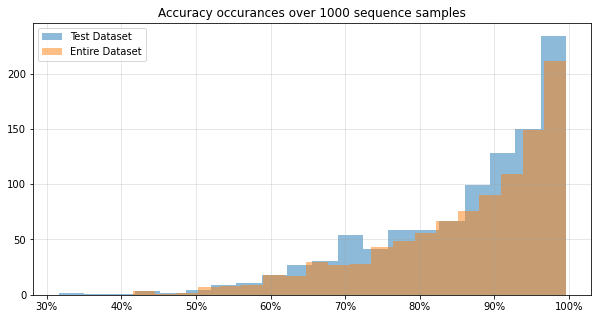

In [92]:
plt.figure(figsize=(10, 5))
plt.hist(resultsList, bins=20, alpha=0.5, label="Test Dataset")
plt.hist(resultsDict.values(), bins=20, alpha=0.5, label="Entire Dataset")
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc='upper left')
plt.grid(True, color="#93a1a1", alpha=0.3)
plt.title('Accuracy occurances over 1000 sequence samples')
plt.show()

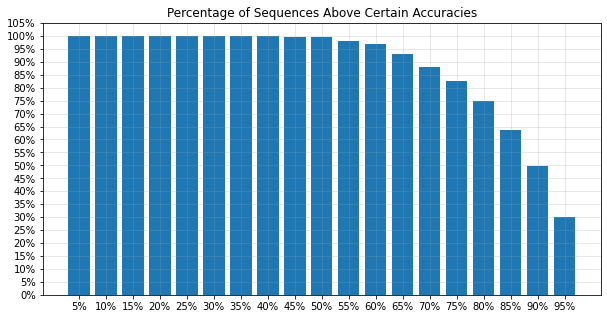

{'5%': 1000, '10%': 1000, '15%': 1000, '20%': 1000, '25%': 1000, '30%': 1000, '35%': 1000, '40%': 1000, '45%': 997, '50%': 994, '55%': 982, '60%': 967, '65%': 931, '70%': 880, '75%': 827, '80%': 748, '85%': 635, '90%': 496, '95%': 300}


In [26]:
percentageDict = {}
for i in resultsDict.values():
    for x in range(1, 20):
        percent = str(x*5)+"%"
        if i > x*0.05:
            percentageDict[percent] = percentageDict.get(percent, 0)+1
            
plt.figure(figsize=(10, 5))
plt.grid(True, color="#93a1a1", alpha=0.3)

plt.bar(*zip(*percentageDict.items()))

plt.title('Percentage of Sequences Above Certain Accuracies')

plt.gca().yaxis.set_major_formatter(PercentFormatter(1000))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(50))

plt.show()
print(percentageDict)

In [64]:
def prettyPrint(location):
    def listToStr(lst):
        return ''.join(lst)
    print(location)
    print(resultsDict[location])
    seq = a[location]
    print(listToStr(seq))
    print('Actual:')
    actual = listToStr(b[location])
    print(actual)
   
    x = dataPrepare([seq], aaDict, 20)
    output = np.argmax(model.predict(x), axis=-1)
    decodedList = [ssDictInverted[q] for q in output[0]]
    print(len(decodedList))
    print(listToStr(decodedList))
    
sortList = sorted(resultsDict, key=resultsDict.get)
top = sortList[-410]
bottom =sortList[1]
prettyPrint(top)
prettyPrint(bottom)

('3V90', 'A')
0.9279999732971191
MTDQAFVTLTTNDAYAKGALVLGSSLKQHRTSRRLAVLTTPQVSDTMRKALEIVFDEVITVDILDSGDSAHLTLMKRPELGVMLTKLHCWSLTQYSKCVFMDADTLVLANIDDLFEREELSAAPDPGWPDCFNSGVFVYQPSVETYNQLLHVASEQGSFDGGDQGLLNTFFNSWATTDIRKHLPFIYNLSSISIYSYLPAFKAFGANAKVVHFLGQTKPWNYTYDTKTKSVRSMTHPQFLNVWWDIFTTSVVPLLQQFGL
Actual:
-TTEEEEEEESSHHHHHHHHHHHHHHHHTT--SEEEEEE-TTS-HHHHHHHHHH-SEEEE--TTSTTSTTHHHHHHSGGGHHHHHHGGGGG-TTSSEEEEE-TTEEE-S--GGGGGS-SSEEEE-SSSTTSEEEEEEEE---HHHHHHHHHHHHHH--TTSSHHHHHHHHTTTTTTS-GGGB--GGGSEETTHHHHTHHHHHHHGGG-SEEE--SSS-GGGS-EETTTTEE-----THHHHHHHHHIIIIIHHHHTTTT-
250
SSHHHHHHHHHHHHHHHHTT--SEEEEEE-TTS-HHHHHHHHH--SEE----TTTTTTTTHHHHHHSGGHHHHHHGGGGGG-TTSSEEEEE-TTEEE-S--GGGGGSSSSEEEE-SSSTTSEEEEEEEE---HHHHHHHHHHHHHH--TTSSHHHHHHHHTTTTTTS-GGG---GGGSEETHHHHHHHHHHHHHGGG--EEE--SSS-GGG-EEETTTTEE-----HHHHHHHHHHIIIIIHHHHHHT--
('5HX2', 'B')
0.41999998688697815
MNDSSVIYRAIVTSKFRTEKMLNFYNSIGSGPDKNTIFITFGRSEPWSSNENEVGFAPPYPTDSVLGVTDMWTHMMGTVKVLPSMLDAVIPRRDWGDTRYPDPYTFRINDIVVCNSAPYNATESGAGWLVYRCLDVPDTGMCSIASLT

Please note, predictions are truncated when run inside Python. When served via Tensorflow Serving, the sequence length is uncapped.

In [39]:
reformat_pred = np.argmax(predictions, axis =-1)
reformat_true = np.argmax(b_test, axis =-1)

print(howClose(reformat_pred, reformat_true))

(0.6663633180250529,  0.7414674775945088)

Using the definition function in order to find the average definition for the full set.